In [1]:
import numpy as np

表征：节点与节点前后的迭代关系（后一层的输入是前一层的输出）

In [2]:
class Node:                         #创建一个 Node的 类
    def __init__(self, inputs=[]):  # self 实例，inputs是实例属性
        self.inputs = inputs        # inputs为要输入的列表； self对象等于inputs
        self.outputs = []           # self.outputs 默认为空列表
        for n in self.inputs:       
            n.outputs.append(self)  # 实现上一个节点的输出是下个节点的输入
            # set 'self' node as inbound_nodes's outbound_nodes
        self.value = None          # 节点值
        self.gradients = {}        # 节点梯度
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented
        
            

表征：输入层的节点(只能向前传播，不接收)

In [3]:
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.   作为输入节点，所以不需要传输节点 instatiator ？？
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None): 
        '''  向前传播
        Only input node is the node where the value may be passed    只有输入节点是可以传递值的节点作为forward（）的参数。
        as an argument to forward().
        All other node implementations should get the value of the   所有其他节点实现都应该获得来自self.inbound_节点的上一个节点
        previous node from self.inbound_nodes        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.  第一层输入，初始值应该是它本身

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        # 输入子类只保存一个值，如数据特征或模型参数（权重/偏差）
    def backward(self):
        self.gradients = {self:0} # initialization   初始化self梯度
        for n in self.outputs:     #遍历 实例的 输出
            grad_cost = n.gradients[self]   
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N

表征： 节点的线性计算y = wx+b

In [4]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):   #实例的属性值包括（节点（上一层的输出结果），权重w，偏差b）
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value         #输入的是inputs列表中第一个元素的值 
        weights = self.inputs[1].value        #权重是 inputs列表中第二个元素的值
        bias = self.inputs[2].value           #bias 是 inputs列表中第三个元素的值 

        self.value = np.dot(inputs, weights) + bias  #矩阵乘法 inputs × weights （1×n乘 n×1 等于1个数值） + bias
        
    def backward(self):
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T) #反向传播组合
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost) #反向传播组合
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False) #反向传播组合

        # WX + B / W ==> X
        # WX + B / X ==> W

表征： 节点的sigmoid激活函数

In [5]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.

表征：loss function MSE

In [6]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


表征： 向前，向后传播函数

In [7]:

def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

表征：拓扑排序

用Kahn算法对一般节点进行拓扑排序。feed_dict`：一个字典，其中键是一个“Input”节点，值是该节点的相应值feed。返回已排序节点的列表。

In [8]:
def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


沿着梯度方向，学习率 1e-2，更新参数值

In [9]:
def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

载入数据集

In [10]:
from sklearn.datasets import load_boston

In [11]:
data = load_boston()

In [12]:
losses = []

In [13]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data  #标准化
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000   #迭代5000次
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 217.667
Epoch: 101, Loss: 7.928
Epoch: 201, Loss: 5.697
Epoch: 301, Loss: 5.325
Epoch: 401, Loss: 4.277
Epoch: 501, Loss: 4.422
Epoch: 601, Loss: 4.841
Epoch: 701, Loss: 4.334
Epoch: 801, Loss: 4.773
Epoch: 901, Loss: 3.992
Epoch: 1001, Loss: 3.874
Epoch: 1101, Loss: 4.101
Epoch: 1201, Loss: 3.866
Epoch: 1301, Loss: 3.697
Epoch: 1401, Loss: 3.910
Epoch: 1501, Loss: 3.303
Epoch: 1601, Loss: 3.662
Epoch: 1701, Loss: 3.741
Epoch: 1801, Loss: 3.798
Epoch: 1901, Loss: 3.706
Epoch: 2001, Loss: 3.666
Epoch: 2101, Loss: 4.041
Epoch: 2201, Loss: 3.722
Epoch: 2301, Loss: 3.737
Epoch: 2401, Loss: 3.909
Epoch: 2501, Loss: 3.771
Epoch: 2601, Loss: 3.659
Epoch: 2701, Loss: 3.813
Epoch: 2801, Loss: 2.905
Epoch: 2901, Loss: 3.421
Epoch: 3001, Loss: 3.399
Epoch: 3101, Loss: 3.921
Epoch: 3201, Loss: 3.510
Epoch: 3301, Loss: 3.754
Epoch: 3401, Loss: 3.191
Epoch: 3501, Loss: 3.462
Epoch: 3601, Loss: 3.963
Epoch: 3701, Loss: 3.157
Epoch: 3801, Loss: 3.571
Epoc

In [14]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [15]:
forward(l2,graph)

array([[20.93267421],
       [49.35036771],
       [33.29664394],
       [15.20626827],
       [30.18593599],
       [13.07325767],
       [17.02880881],
       [20.63705905],
       [18.68481838],
       [31.00998823],
       [23.93937779],
       [10.45296923],
       [23.54223323],
       [17.41337829],
       [32.71856478],
       [24.98264937]])

In [16]:
import matplotlib.pyplot as plt

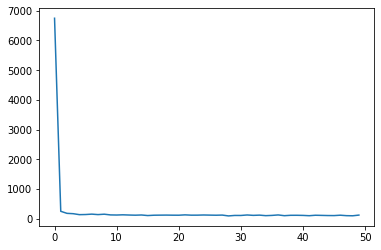

In [17]:
plt.plot(range(len(losses)), losses)

In [18]:
W2.value

array([[ 9.16470261],
       [ 4.39189181],
       [ 8.94895531],
       [11.56667321],
       [-4.64983392],
       [11.18344666],
       [11.64152758],
       [ 9.02670822],
       [ 6.07092023],
       [-3.68203322]])

In [19]:
X_ = data['data']

In [20]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])